# Assignment 6: Viola&Jones
Read the paper by Viola and Jones. You can find it in "mycampus/resources/papers".

## Ex. 6.1 Rectangular Features
Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper). How many exist? **(RESULT)** Display three of these overlaid onto an image of a face. **(RESULT)**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io


"""
>>> np.concatenate([np.ones((3,3)), np.zeros((3,3))])
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])
>>> np.concatenate([np.ones((3,3)), np.zeros((3,3))], axis=1)
array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.]])
"""

ones = np.ones
neg_ones = lambda shape: np.ones(shape) * -1


def get_2rect_mask(width, height, vertical, inverse):
    shape = (height, width)
    axis = 0 if vertical else 1
    seq = (
        (ones(shape), neg_ones(shape))
        if not inverse
        else (neg_ones(shape), ones(shape))
    )
    return np.concatenate(seq, axis=axis)

def get_all_2rect_masks(width, height):
    """
    :param width: Width of a SUB region (white OR black).
    :param height: Height of a SUB region (white OR black).
    """
    return (
        get_2rect_mask(width, height, vertical=True, inverse=False),
        get_2rect_mask(width, height, vertical=True, inverse=True),
        get_2rect_mask(width, height, vertical=False, inverse=False),
        get_2rect_mask(width, height, vertical=False, inverse=True),
    )
                   
def apply_mask(img, x, y, mask):
    height, width = mask.shape
    return img[y:(y + height), x:(x + width)] * mask

def feature_val(img, x, y, feature):
    return np.sum(apply_mask(img, x, y, feature))

                   
def construct_features(width, height, kind=2):
    def rect2(width, height):
        """
        We initially only compute the features such that
        the "white" area is only left for horizontally shaped
        and only top for vertically shaped areas.
        Finally, we add all flipped variants (of all results).
        
        The white area can max be half the size of the window.
        """
        features = []                   
        for y in range(1, height + 1):
            for x in range(1, width + 1):
                if x <= width // 2 or y <= height // 2:
                    features += get_all_2rect_masks(x, y)
        max_shape = np.array([height, width])
        return [
            feature 
            for feature in features
            if np.all(np.array(feature.shape) <= max_shape)
        ]
    
    if kind == 2:
        return rect2(width, height)
    raise NotImplementedError('Currently only 2-rect features are supported.')

    
two_rect_features = construct_features(24, 24)
print("Number of features =", len(two_rect_features))

fig = plt.figure(figsize=(18, 160), dpi=72)
fig.tight_layout()
for i, feature in enumerate(sorted(two_rect_features, key=lambda f: f.shape), start=1):
    ax = plt.subplot(144, 8, i)
    h, w = feature.shape
    ax.set_xticks([0, w - 1])
    ax.set_yticks([0, h - 1])
    ax.imshow(feature, cmap='gray', vmin=-1, vmax=1)
plt.savefig("06_features_2rect.png")

None

Number of features = 1152


Feature coords and shapes:
6 10 (6, 10)
11 16 (8, 12)
13 0 (12, 11)


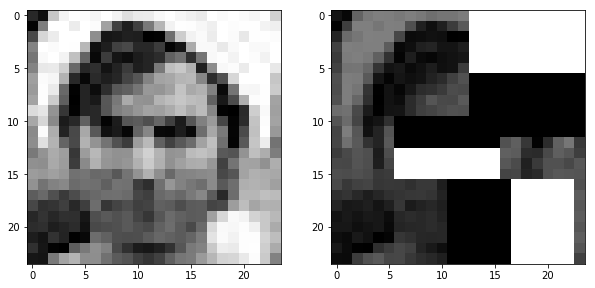

In [2]:
from collections import defaultdict
from multiprocessing import Pool

from skimage import io, color
from tqdm import tqdm


face_rgb = io.imread('images/face_taco.jpg')
face = color.rgb2gray(face_rgb)

size = face.shape[0]
half = size // 2

def task(img_segment, y0, x0):
    h, w = img_segment.shape
    results = []
    for y in range(y0, y0 + h):
        for x in range(x0, x0 + w):
            for feature in two_rect_features:
                fh, fw = feature.shape
                if x + fw <= size and y + fh <= size:
                    val = feature_val(face, x, y, feature)
                    results.append((x, y, feature, val))
    return results

with Pool() as pool:
    feature_values_2d = pool.starmap(
        task,
        # Image quadrants. Unequal computation load but something...
        [
            (face[:half, :half], 0, 0),
            (face[half:, :half], half, 0),
            (face[:half, half:], 0, half),
            (face[half:, half:], half, half),
        ],
    )

def get_best_feature(feature_values):
    return sorted(
        # Select features with 2x2 <= size <= 10x10 to be able to see them on the grayscale image.
        [
            tup 
            for tup in feature_values 
            if (
                tup[2].shape[0] >= 4
                and tup[2].shape[1] >= 8
                and tup[2].shape[0] <= 12
                and tup[2].shape[1] <= 12
            )
        ],
        key=lambda tup: tup[-1], 
        reverse=True,
    )[0]


# # Show feature per quadrant.
# print(len(feature_values_2d[0]), len(feature_values_2d[1]), len(feature_values_2d[2]), len(feature_values_2d[3]))

# # Find index of eye-matching feature.
# for i, t in enumerate(feature_values_2d[0]):
#     x, y, f, v = t
#     h, w = f.shape
#     if h == 6 and w == 10 and x == 6 and y == 10:
#         print(i)
#         print(x, y, f.shape, v)

best_features = [
    # Arbitrarily picked the feature matching the eye region. It has a surprinsingly low value though...
    feature_values_2d[0][88015],
    get_best_feature(feature_values_2d[1]),
    get_best_feature(feature_values_2d[2]),
]

face_with_features = np.copy(face) * 0.5
print('Feature coords and shapes:')
for x, y, feature, _ in best_features:
    fh, fw = feature.shape
    print(x, y, feature.shape)
    # Subtract 1 from black region, add 1 to white region.
    face_with_features[y:(y + fh), x:(x + fw)] += feature
face_with_features = np.clip(face_with_features, 0, 1)

fig = plt.figure(figsize=(10, 5), dpi=72)
fig.tight_layout()
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(face, cmap='gray')
ax2.imshow(face_with_features, cmap='gray')

None

## Ex. 6.2 Integral Image 
Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. Compare it to the output of skimage's integral_image() function. **(RESULT)**

Are the 2 integral images equal? Yes.


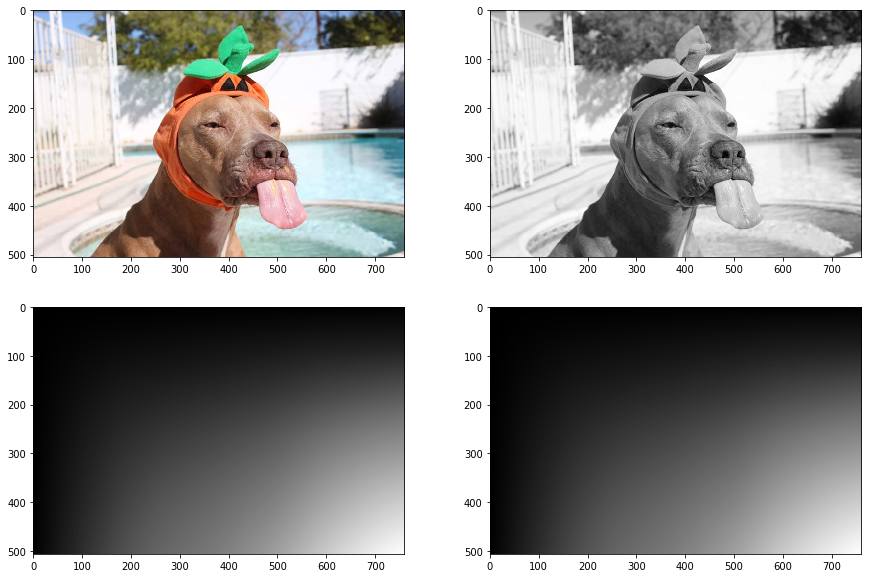

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, io, transform


input_image = io.imread("images/dog.jpg")
input_image_gray = color.rgb2gray(input_image)

def integral_image(img):
    h, w = shape = img.shape
    # Make matrices bigger so we don't have to have if-else for s(x, -1) = 0 and ii(-1, y) = 0
    # In the end, we just ignore those extra row and column to get back the original size.
    s = np.zeros((h + 1, w + 1))
    ii = np.zeros((h + 1, w + 1))
    for y in range(1, h + 1):
        for x in range(1, w + 1):
            s[y, x] = s[y - 1, x] + img[y - 1, x - 1]
            ii[y, x] = ii[y, x - 1] + s[y, x]
    return ii[1:, 1:]


ii_self = integral_image(input_image_gray)
ii_skimage = transform.integral_image(input_image_gray)

print('Are the 2 integral images equal?', 'Yes.' if np.all(ii_self == ii_skimage) else 'No.')


fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(input_image)
ax12.imshow(input_image_gray, cmap='gray')
ax21.imshow(ii_self, cmap='gray')
ax22.imshow(ii_skimage, cmap='gray')


None

# Ex. 6.3 AdaBoosting
Implement the AdaBoost algorithm as outlined in the paper. Train a 20-feature classifier using these datasets: 
    
faces and non-faces:    www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

Test your classifier with different thesholds and visualize the ROC curve **(RESULTS)**

In [76]:
# Create all possible features, by shifting each rect through the image width and height
def shift_rects(rect_list, w, h):
    feats = []
    for rect in rect_list:
        for x in range(w-rect.shape[1]+1):
            for y in range(h-rect.shape[0]+1):
                feat = np.zeros((w,h))
                feat[x:x+rect.shape[1],y:y+rect.shape[0]] = rect.T
                feats.append(feat)
    
    return feats


# weights, eps_t -> vectors with the size of the sample count
# We need the information of correct or incorrect classification of each sample: 
# e -> vector with 0 for correct, 1 for incorrect classification - has to be a return value of the weak learner function
# for loop for now :D
def weight_update_of_weak_classifier(weights, e, eps_t):
    beta_t = eps_t / (1-eps_t)
    weights_new = np.copy(weights)

    for i in range(len(weights)-1):
        weights_new[i] = weights[i] * np.power(beta_t, 1-e[i])
    return weights_new, beta_t


# x -> input image
# beta_vec -> vector of beta value of the weak learners
# def h_t should return the weak classifier output for image x
def strong_classifier(x, beta_vec, T=20):
    alpha = []
    weak_classifier = []
    
    for t in range(T):
        # Somehow get weak classifier output
        weak_classifier_t = h_t(x)
        alpha_t = np.log(np.power(beta_vec[t], -1))
        
        alpha.append(alpha_t)
        weak_classifier.append(weak_classifier_t)
        
    threshold = .5 * np.sum(alpha)
    condition = (np.sum(alpha_t) * np.sum(weak_classifier)) >= threshold 
    
    C_x = 1 if condition else 0    
    return C_x



        
        
# small testing
test_weights = np.array([0.5,0.5,0.5])
test_e = np.array([0,0,1])
test_eps_t = .1
updated_weights, beta = weight_update_of_weak_classifier(test_weights, test_e, test_eps_t)
print(new_weights)

[ 0.05555556  0.05555556  0.5       ]


684
68400
(198,)


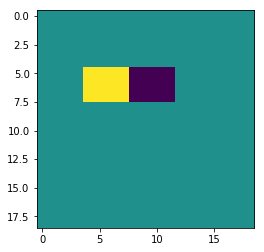

In [77]:
# For now only select a few images.
faces = io.imread_collection("images/faces/train/face/face000*")
non_faces = io.imread_collection("images/faces/train/non-face/B1_000*")

# NOTE: All following notation as in the paper.
l, m = len(faces), len(non_faces)
n = l + m
T = 20
theta = 0.5

x_train = np.concatenate((np.array(faces), np.array(non_faces)))
y_train = np.concatenate((np.ones((l,)), np.zeros(m,)))

# Because of our 19x19 input pics
height = width = 19
two_rect_list = construct_features(width, height)
print(len(two_rect_list))

feats = shift_rects(two_rect_list, width, height)
print(len(feats)) 

# Show 1 test feature
plt.imshow(feats[30000])

weights_faces = np.zeros((l,))
weights_non_faces = np.zeros((m,))
weights_faces[:] = 1 / (2*l)
weights_non_faces[:] = 1 / (2*m)

weights = np.concatenate((weights_faces, weights_non_faces), axis=0)
print(weights.shape)

"""
def select_weak_classifier(x, y, w, feats):
    p = 1
    output = []
    
    for i, x_i in enumerate(1):
        ii_xi = transform.integral_image(x_i)
#         plt.imshow(ii_xi)

        for feat in feats:
#             f_xi = x_i + feat
"""

for t in range(T):
    # 1. Normalize the weights
    weights = weights / np.sum(weights)
#     h_t = select_weak_classifier(x_train, y_train, weights, feats)

    # TODO ..

In [ ]:
from abc import abstractmethod

import numpy as np


class Model:
    @abstractmethod
    def fit(self, X_train, y_train):
        """
        :param X_train: np.array shape=(N, M) Input matrix
        :param y_train: np.array shape=(N,)   Labels for inputs such that X_i -> y_i
        
        Uses training data for fit the model.
        """
    
    @abstractmethod
    def predict(self, X):
        """
        :param X: np.array (K, M) Input matrix to predict labels for.
        
        Returns labels (given as y_train in self.fit) for all x in X.
        """
    
    def get_confusion_matrix(self, X_test, y_test):
        classes = np.unique(y_test)
        matrix = np.zeros(shape=(classes, classes))
        for i, x in enumerate(X_test):
            given_label = y_test[i]
            given_label_index = np.where(classes == given_label)[0]
            predicted_label = self.predict(x)
            predicted_label_index = np.where(classes == predicted_label)[0]
            matrix[given_label_index][predicted_label_index] += 1
        return matrix
    
    def get_score(self, X_test, y_test, print_score=True, print_confusion_matrix=False):
        matrix = self.get_confusion_matrix(X_test, y_test)
        score = np.sum(np.diag(matrix)) / len(X_test)
        if print_confusion_matrix:
            print('confusion matrix =', matrix)
        if print_score:
            print('accuracy =', score)
        return score

    
class AdaBoost(Model):
    def __init__(self, *, T):
        self.T = T
        
    def fit(self, X_train, y_train):
        return

    def predict(self, X):
        pass


def convert_mask_feature_to_integral_lookups(x, y, feature):
    """
    :param feature: np.array A bound feature (see doctstring below).
    
    A factory for as-in-the-paper features from the feature we generated in ex6.1
    (2-rect only!).
    """
    fh, fw = feature.shape
    is_vertical = feature[0, 0] != feature[0, -1]
    white_first = feature[0, 0] == 1

    # NOTE: The order of corners is like in the paper (tl, tr, bl, br).
    if is_vertical:
        white_rect = (
            (y, x),
            (y, x + fw/2),
            (y + fh, x),
            (y + fh, x + fw/2),
        )
        black_rect = (
            (y, x + fw/2),
            (y, x + fw),
            (y + fh, x + fw/2),
            (y + fh, x + fw),
        )
        if not white_first:
            white_rect, black_rect = black_rect, white_rect
    else:
        white_rect = (
            (y, x),
            (y, x + fw),
            (y + fh/2, x),
            (y + fh/2, x + fw),
        )
        black_rect = (
            (y + fh/2, x),
            (y + fh/2, x + fw),
            (y + fh, x + fw),
            (y + fh, x + fw),
        )
        if not white_first:
            white_rect, black_rect = black_rect, white_rect
    return lambda ii: (
        (ii[white_rect[3]] + ii[white_rect[0]] - ii[white_rect[1]] - ii[white_rect[2]])
        - (ii[black_rect[3]] + ii[black_rect[0]] - ii[black_rect[1]] - ii[black_rect[2]])
    )
    
    
def combined_ii_features(features, height, width):
    """
    Generates all possible combinations of general features with possible pixel positions.
    Let's call these 'bound features'.
    Also converts all of these into function that perform lookups in the integral image (ii).
    Thus, this function returns features as meant in the paper.
    """
    results = []
    for y in range(height):
        for x in range(width):
            for feature in features:
                fh, fw = feature.shape
                if x + fw <= width and y + fh <= height:
                    results.append(
                        convert_mask_feature_to_integral_lookups(x, y, feature)
                    )
    return results
    

In [ ]:
from skimage import io


# For now only select a few images.
faces = io.imread_collection("images/faces/train/face/face000*")
non_faces = io.imread_collection("images/faces/train/non-face/B1_000*")

# print(len(faces))
# print(len(non_faces))

# print(type(faces))
# <class 'skimage.io.collection.ImageCollection'>
# print(type(faces[0]))
# <class 'numpy.ndarray'>

# NOTE: All following notation as in the paper.
l, m = len(faces), len(non_faces)
n = l + m
T = 20

x_train = np.concatenate((np.array(faces), np.array(non_faces)))
y_train = np.concatenate((np.ones((l,)), np.zeros(m,)))

# print(x_train.shape, y_train.shape)

height = width = 24
two_rect_features = construct_features(width, height)
features = combined_ii_features(two_rect_features, height, width)
# print(len(features))
# 172800

# weights = np.zeros((n,))
# weights[:l] = 1 / (2 * l)
# weights[l:] = 1 / (2 * m)
# print(weights[1:].shape)

weights_faces = np.zeros((l,))
weights_non_faces = np.zeros((m,))
weights_faces[:] = 1 / (2*l)
weights_non_faces[:] = 1 / (2*m)

weights = np.concatenate((weights_faces, weights_non_faces), axis=0)


 

def h(x, f, p, theta):
    for x_i in x:
        h = x
    

def select_best_weak_classifier(x, y, w, features):
    theta = 0.5
    p = 1
    output = []
    print(features[200])
    
    for i, x_i in enumerate(x):
        X_iii = transform.integral_image(x_i)
        
        for weak_c in features:
#             print(feature.shape)
#             print(x_i.shape)
            
             h = x 
            
#             e_t = abs(h - y)
#             e_t = np.sum()

    
    
    


for t in range(T):
    # 1. Normalize the weights
    weights = weights / np.sum(weights)
#     print(weights)
#     print(x_train.shape[0])
    h_t = select_best_weak_classifier(x_train, y_train, weights, features)